In [4]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('flights.csv') 
select_features = ['','wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z']
data, train_loader, val_loader, test_loader = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
                                                               features=select_features, covariates=False)
# features = getFeatures()

30


In [6]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 32])
torch.Size([64, 10])


In [7]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)

        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(features)
input_len = 24
output_len = 10
hidden_size = 32  
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [64,64,64,64], hidden_size, num_layers=num_layers).to(device)

cuda


In [15]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 20
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.4f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.4f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_best_model_{input_len}-{output_len}.pt')


Epoch 1/20 [TRAIN]: 100%|██████████| 2348/2348 [00:40<00:00, 58.30it/s, train_loss=0.0021] 


Epoch 1/20, Average Training Loss: 0.0026


Epoch 1/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 140.29it/s, val_loss=1.79e-5] 


Epoch 1/20, Average Validation Loss: 0.0026


Epoch 2/20 [TRAIN]: 100%|██████████| 2348/2348 [00:38<00:00, 61.07it/s, train_loss=0.00265] 


Epoch 2/20, Average Training Loss: 0.0025


Epoch 2/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 148.06it/s, val_loss=4.61e-6] 


Epoch 2/20, Average Validation Loss: 0.0024


Epoch 3/20 [TRAIN]: 100%|██████████| 2348/2348 [00:40<00:00, 58.64it/s, train_loss=0.00318]


Epoch 3/20, Average Training Loss: 0.0025


Epoch 3/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 152.18it/s, val_loss=3.45e-5] 


Epoch 3/20, Average Validation Loss: 0.0024


Epoch 4/20 [TRAIN]: 100%|██████████| 2348/2348 [00:38<00:00, 60.25it/s, train_loss=0.00186]


Epoch 4/20, Average Training Loss: 0.0024


Epoch 4/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 156.62it/s, val_loss=7.15e-6] 


Epoch 4/20, Average Validation Loss: 0.0028


Epoch 5/20 [TRAIN]: 100%|██████████| 2348/2348 [00:40<00:00, 57.43it/s, train_loss=0.00243]


Epoch 5/20, Average Training Loss: 0.0024


Epoch 5/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 143.18it/s, val_loss=6.4e-6]  


Epoch 5/20, Average Validation Loss: 0.0023


Epoch 6/20 [TRAIN]: 100%|██████████| 2348/2348 [00:43<00:00, 54.59it/s, train_loss=0.00157]


Epoch 6/20, Average Training Loss: 0.0023


Epoch 6/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 138.74it/s, val_loss=1.84e-5] 


Epoch 6/20, Average Validation Loss: 0.0023


Epoch 7/20 [TRAIN]: 100%|██████████| 2348/2348 [00:44<00:00, 53.18it/s, train_loss=0.00185] 


Epoch 7/20, Average Training Loss: 0.0023


Epoch 7/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 140.82it/s, val_loss=1.74e-5] 


Epoch 7/20, Average Validation Loss: 0.0023


Epoch 8/20 [TRAIN]: 100%|██████████| 2348/2348 [00:43<00:00, 54.25it/s, train_loss=0.00231] 


Epoch 8/20, Average Training Loss: 0.0022


Epoch 8/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 139.53it/s, val_loss=5.01e-6] 


Epoch 8/20, Average Validation Loss: 0.0023


Epoch 9/20 [TRAIN]: 100%|██████████| 2348/2348 [00:46<00:00, 50.85it/s, train_loss=0.00287] 


Epoch 9/20, Average Training Loss: 0.0022


Epoch 9/20 [VAL]: 100%|██████████| 804/804 [00:05<00:00, 137.51it/s, val_loss=7.11e-6] 


Epoch 9/20, Average Validation Loss: 0.0022


Epoch 10/20 [TRAIN]: 100%|██████████| 2348/2348 [00:42<00:00, 55.37it/s, train_loss=0.00198] 


Epoch 10/20, Average Training Loss: 0.0022


Epoch 10/20 [VAL]: 100%|██████████| 804/804 [00:06<00:00, 131.23it/s, val_loss=1.6e-5]  


Epoch 10/20, Average Validation Loss: 0.0022


Epoch 11/20 [TRAIN]: 100%|██████████| 2348/2348 [00:43<00:00, 54.32it/s, train_loss=0.00251] 


Epoch 11/20, Average Training Loss: 0.0022


Epoch 11/20 [VAL]: 100%|██████████| 804/804 [00:06<00:00, 129.27it/s, val_loss=1.86e-5] 


Epoch 11/20, Average Validation Loss: 0.0023


Epoch 12/20 [TRAIN]:  98%|█████████▊| 2297/2348 [00:43<00:00, 52.57it/s, train_loss=0.00212] 

Test loss: 0.003686991985887289
MAPE: 32.473609924316406


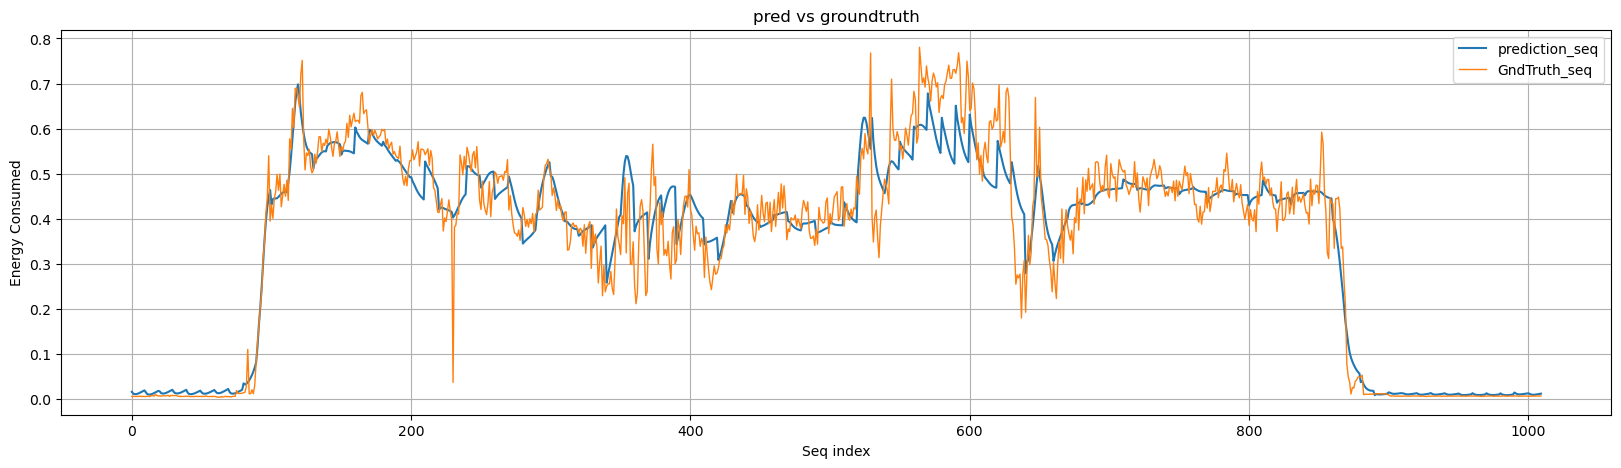

In [10]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load('TCN_LSTM_best_model_24-10.pt'))

# Test the model
seq2seq.eval()
flight_num = 79 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[features].values, 
                                         test_data['power'].values,24,10)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [14]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 40.78846660410006


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""